# Building a deep belief network

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt

from tqdm import tqdm

import sys
sys.path.append('../..')

from logger import setup_logging
from models import DBN
from utils import (
    dataset,
    test,
    train,
    utils,
    visualisation
)

/Users/othmanebelarbi/Documents/DBN-FL/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LOG_CONFIG_PATH = os.path.join(os.path.abspath("../.."), "logger", "logger_config.json")
LOG_DIR   = os.path.join(os.path.abspath("../.."), "logs")
DATA_DIR  = os.path.join(os.path.abspath("../.."), "data")
IMAGE_DIR = os.path.join(os.path.abspath("../.."), "images")

Check if GPU is active.

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


In [ ]:
utils.mkdir(LOG_DIR)
setup_logging(save_dir=LOG_DIR, log_config=LOG_CONFIG_PATH)

### Create the DataLoader

In [4]:
# Get the datasets
train_data, val_data, test_data = dataset.get_dataset(data_path=DATA_DIR, balanced=False)

# How many instances have we got?
print('# instances in training set: ', len(train_data))
print('# instances in validation set: ', len(val_data))
print('# instances in testing set: ', len(test_data))

batch_size = 128

# Create the dataloaders - for training, validation and testing
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

# instances in training set:  1318783
# instances in validation set:  439595
# instances in testing set:  439595


### Instantiate the network, the loss function and the optimizer

In [5]:
# Defining some input variables
n_classes = 6
num_epochs = 3

# Creating a DBN
model = DBN(n_visible=49,
            n_hidden=(128, 64),
            k=(1, 1),
            learning_rate=(0.1, 0.1),
            momentum=(0, 0),
            decay=(0, 0), 
            batch_size=[64, 64],
            num_epochs=[1, 1],
            device=device)

# Training a DBN
model.fit(train_loader)

# Creating the optimzers
optimizer = [optim.Adam(m.parameters(), lr=0.001) for m in model.models]
optimizer.append(optim.Adam(model.fc.parameters(), lr=0.001))

Fitting layer 1/2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10303/10303 [06:41<00:00, 25.65it/s]


Epoch 1/1 - MSE: 6.858296871185303 - Pseudo-Likelihood: -13.392290115356445
Fitting layer 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 20606/20606 [00:54<00:00, 380.51it/s]


Epoch 1/1 - MSE: 20.831422805786133 - Pseudo-Likelihood: -40.55342102050781


In [6]:
print(model)

DBN(
  (fc): Linear(in_features=64, out_features=6, bias=True)
)


In [8]:
criterion = nn.CrossEntropyLoss()

### Train it

In [9]:
history = train(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device)

training_loss = history['train']['loss']
training_accuracy = history['train']['accuracy']
train_output_true = history['train']['output_true']
train_output_pred = history['train']['output_pred']

validation_loss = history['valid']['loss']
validation_accuracy = history['valid']['accuracy']
valid_output_true = history['valid']['output_true']
valid_output_pred = history['valid']['output_pred']

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10303/10303 [06:33<00:00, 26.17it/s]


### Plot loss vs iterations

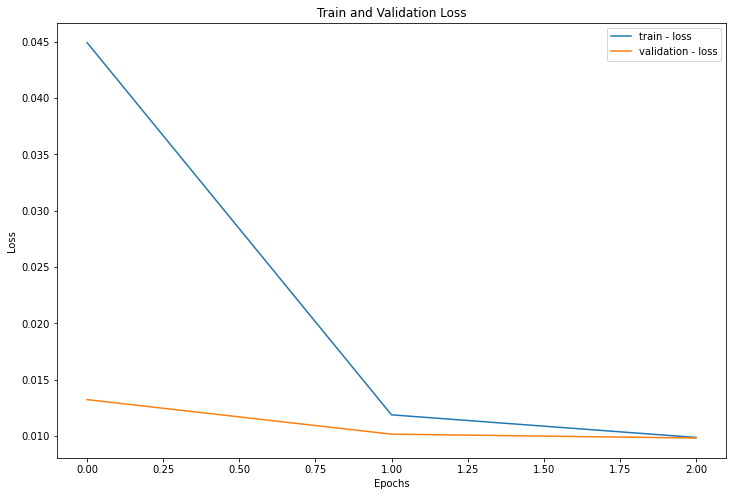

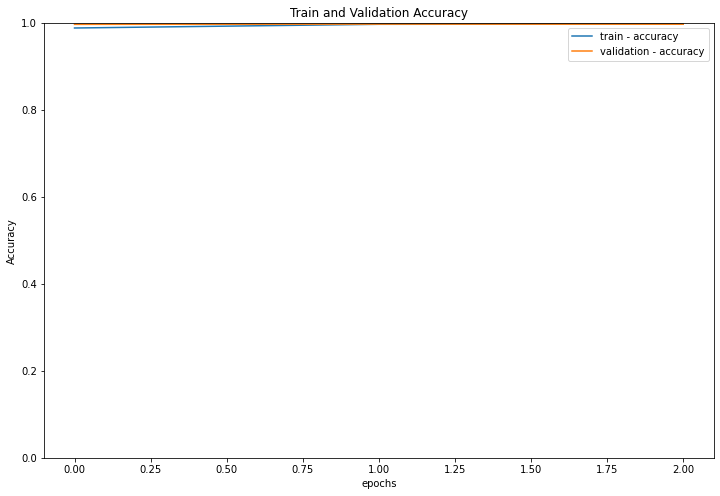

In [10]:
fig = plt.figure(figsize=(12, 8))
plt.plot(training_loss, label='train - loss')
plt.plot(validation_loss, label='validation - loss')
plt.title("Train and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

fig = plt.figure(figsize=(12, 8))
plt.plot(training_accuracy, label='train - accuracy')
plt.plot(validation_accuracy, label='validation - accuracy')
plt.title("Train and Validation Accuracy")
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend(loc="best")
plt.show()

### Plot confusion matrix

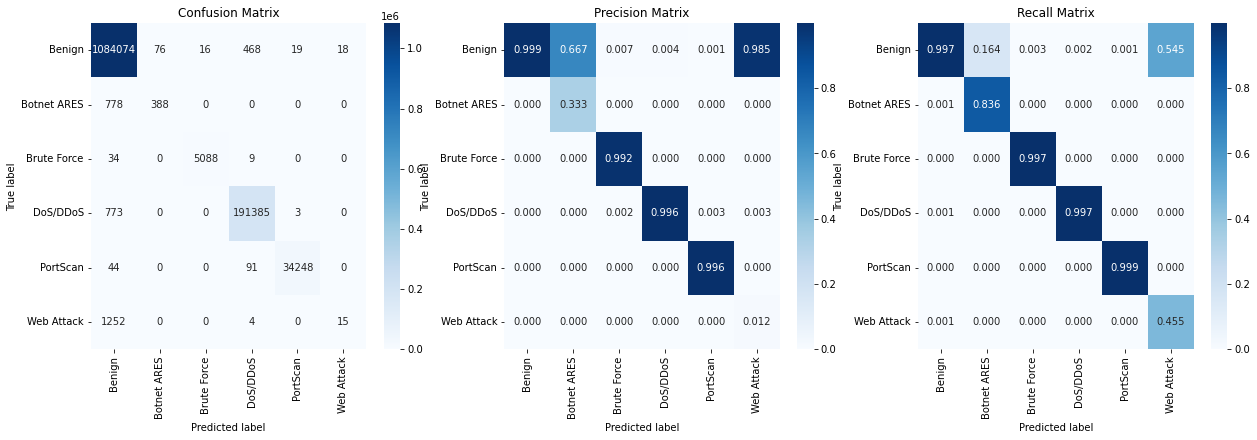

In [11]:
labels = ['Benign', 'Botnet ARES', 'Brute Force', 'DoS/DDoS', 'PortScan', 'Web Attack']

visualisation.plot_confusion_matrix(y_true=train_output_true,
                                    y_pred=train_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_dbn_train_confusion_matrix.pdf")

In [12]:
from sklearn.metrics import classification_report

print("Training Set -- Classification Report", end="\n\n")
print(classification_report(train_output_true, train_output_pred, target_names=labels))

Training Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00   1084671
 Botnet ARES       0.84      0.33      0.48      1166
 Brute Force       1.00      0.99      0.99      5131
    DoS/DDoS       1.00      1.00      1.00    192161
    PortScan       1.00      1.00      1.00     34383
  Web Attack       0.45      0.01      0.02      1271

    accuracy                           1.00   1318783
   macro avg       0.88      0.72      0.75   1318783
weighted avg       1.00      1.00      1.00   1318783



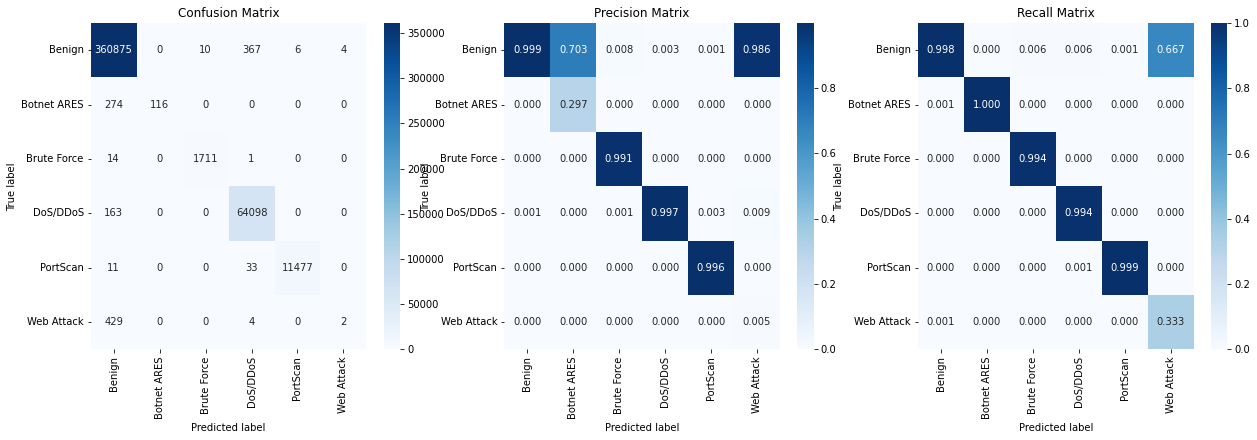

In [13]:
visualisation.plot_confusion_matrix(y_true=valid_output_true,
                                    y_pred=valid_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_dbn_valid_confusion_matrix.pdf")

In [14]:
print("Validation Set -- Classification Report", end="\n\n")
print(classification_report(valid_output_true, valid_output_pred, target_names=labels))

Validation Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    361262
 Botnet ARES       1.00      0.30      0.46       390
 Brute Force       0.99      0.99      0.99      1726
    DoS/DDoS       0.99      1.00      1.00     64261
    PortScan       1.00      1.00      1.00     11521
  Web Attack       0.33      0.00      0.01       435

    accuracy                           1.00    439595
   macro avg       0.89      0.71      0.74    439595
weighted avg       1.00      1.00      1.00    439595



### Test it

In [15]:
#################
### TEST LOOP ###
#################
history = test(model, criterion, test_loader, device)

test_output_true = history['test']['output_true']
test_output_pred = history['test']['output_pred']
test_output_pred_prob = history['test']['output_pred_prob']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3435/3435 [02:13<00:00, 25.74it/s]


### Classification Report

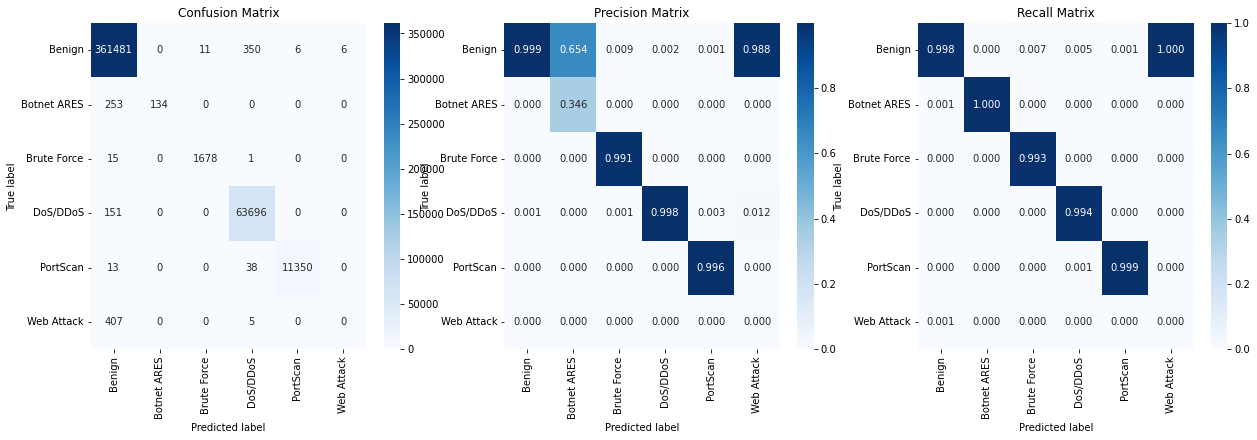

In [16]:
visualisation.plot_confusion_matrix(y_true=test_output_true,
                                    y_pred=test_output_pred,
                                    labels=labels,
                                    save=True,
                                    save_dir=IMAGE_DIR,
                                    filename="imb_dbn_test_confusion_matrix.pdf")

In [17]:
print("Testing Set -- Classification Report", end="\n\n")
print(classification_report(test_output_true, test_output_pred, target_names=labels))

Testing Set -- Classification Report

              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    361854
 Botnet ARES       1.00      0.35      0.51       387
 Brute Force       0.99      0.99      0.99      1694
    DoS/DDoS       0.99      1.00      1.00     63847
    PortScan       1.00      1.00      1.00     11401
  Web Attack       0.00      0.00      0.00       412

    accuracy                           1.00    439595
   macro avg       0.83      0.72      0.75    439595
weighted avg       1.00      1.00      1.00    439595



### Plot ROC curve

In [18]:
y_test = pd.get_dummies(test_output_true).values
y_score = np.array(test_output_pred_prob)

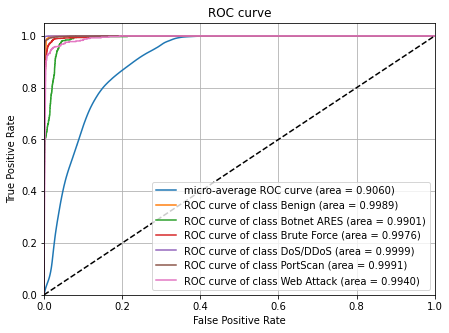

In [19]:
visualisation.plot_roc_curve(y_test=y_test,
                             y_score=y_score,
                             labels=labels,
                             save=True,
                             save_dir=IMAGE_DIR,
                             filename="imb_dbn_roc_curve.pdf")

### Plot Precision vs. Recall curve

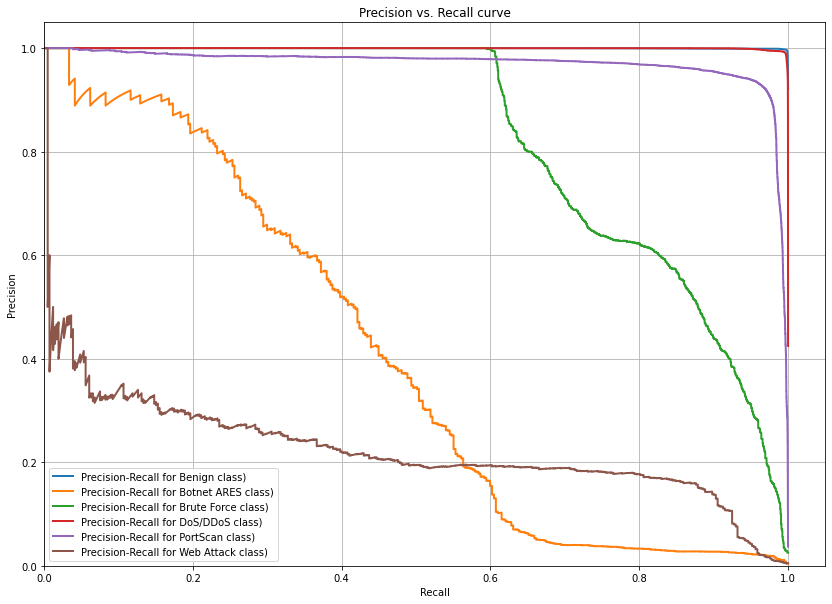

In [20]:
visualisation.plot_precision_recall_curve(y_test=y_test,
                                          y_score=y_score,
                                          labels=labels,
                                          save=True,
                                          save_dir=IMAGE_DIR,
                                          filename="imb_dbn_prec_recall_curve.pdf")

### Save Model

In [21]:
path = '../../checkpoints/imb_deep_belief_network.pt'
torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            }, path)